<h1> <center> Hyperspectral Imaging to classify Vegetative compatability groups (VCGs) of $Verticillium$ $dahliae$ </center></h1> 

**Objectives**

* Classify Vegetative compatibility groups (VCGs) of V. dahliae using hyperspectral imagery
* Evaluate performance of different machine learning models to classify VCGs based on spectral reflectance and texture features

**HSI Analysis Work flow**

* Acquire data
    * Dark reference
    * White reference
    * Data
    * Acquired images for each isolate are in the separate folder. There are total 228 folders. Each folder has dark, white and data image which will be used for the calibration of image.
* Image pre-processing
    * Image calibration
        * calibrated image = $ Rawimage(I)- darkimage(I)/ whiteimage(I)-darkimage(I)$
    * Circular mask creation and Image segementation
    * Calculate mean spectra
    * Normalization
    * Cut first and last four bands for enhanced signal to noise ratio
* Feature Extraction and Selection
    * Feature Extraction/Ordination (PCA, LDA)
    * Feature Selection (LASSO, Random Forest, SVM(linear))
* Inference
    * SVM
    * KNN 
    * Random forest
    * CNN
* Identification and interpretation
* Reference 
    * [Paulus and Mahleing 2020](https://academic.oup.com/gigascience/article/9/8/giaa090/5894826)
    * [Xie et al 2015](https://www.nature.com/articles/srep16564)

## Image Preprocessing

**Import Python Packages**

In [1]:
#Packages 
from spectral import imshow, view_cube
import spectral.io.envi as envi# open envi format images
import spectral as spy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns # plotting
import pandas as pd
from scipy import ndimage
from scipy import misc
import scipy.io
import skimage.draw
import os
import pathlib
from sklearn import preprocessing
from skimage.feature import greycomatrix, greycoprops #texture features
from skimage.transform import resize # resize image

**Wavelength infromation**

In [6]:
h = envi.read_envi_header('data.hdr')#read envi file headers 
#print(h)#print h file 
#print(h['bands'])#print the no. of bands in the image
wavebands = pd.DataFrame(h['wavelength'])

**Read Images**

In [7]:
data = envi.open('data.hdr', 'data')
print(data)
print(data.shape)

	Data Source:   '.\data'
	# Rows:            340
	# Samples:         320
	# Bands:           144
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32
(340, 320, 144)


**Convert image to 3D numpy array**

(340, 320, 144)


ImageView object:
  Display bands       :  [0, 72.0, 143]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 3.0]
    G: [0.0, 2.4702954292297363]
    B: [0.0, 3.0]

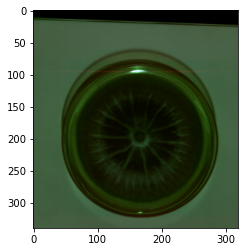

In [8]:
#convert each image to 3D numpy array
df_corrected = np.array(data.load())
print(df_corrected.shape)
imshow(df_corrected)

**Crop image to desired size**

(195, 200, 144)
float32


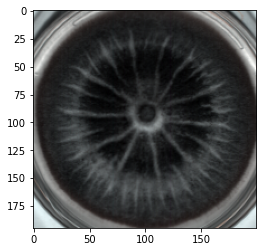

In [12]:
df_cropped1 = df_corrected.copy()
df_cropped = df_cropped1[105:300,65:265,:]
   #change this value according to diameter of isolate
imshow(df_cropped, (29,19,17))# (5x*y*bands) x is in vertical axis and y in horizontal axis of image
print(df_cropped.shape)
print(df_cropped.dtype)

### **Create Circular mask**

(195, 200, 144)


0.15560178

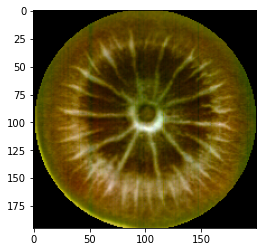

In [13]:
df_mask = df_cropped.copy() #make copy of a cropped image
lx, ly = df_cropped[:,:,17].shape #define the lx and ly based on the height and width of the image
X, Y = np.ogrid[0:lx, 0:ly] # define X and Y 
mask_circular = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4 #develop circular mask
# Masks
df_mask[mask_circular] = 0 # change masked part of the image to zero
imshow(df_mask) #s'how 3D image with mask
print(df_mask.shape)
df_mask.mean()

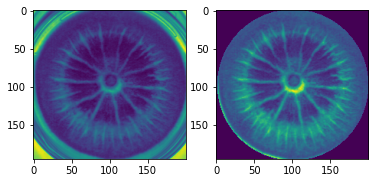

In [14]:
#display both original and mask images 
f, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(df_cropped[:,:,17])
ax1.imshow(df_mask[:,:,17])
plt.show()

* Overlay image with mask

In [15]:
gt = df_mask.copy()
gt = gt[:,:,17]# subset x and y 
gt.shape
df_mask.min()

0.0

**Visualize overlayed image to confirm proper segmentation**

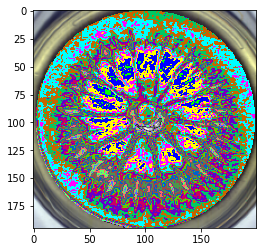

In [16]:
gt = df_mask.copy()
gt = gt[:,:,17]# subset x and y 
#Display image with overlayed class masks
view = imshow(df_cropped, (30, 20, 0), classes=gt)
view.set_display_mode('overlay')
view.class_alpha =1

In [1741]:
img = df_mask.copy()
resized_170 = resize(img, (170, 170))
resized_170.shape

(170, 170, 144)

In [1742]:
img = df_mask.copy()
resized_200 = resize(img, (200, 200))
resized_200.shape

(200, 200, 144)

---

---

In [ ]:
isolate_all = []
data_dir = pathlib.Path('./PreprocessedImages_2021/original/')

for i in list(data_dir.glob('*.npy')):
    
    #Isolate name
    head, tail = os.path.split(i)
    name = tail.replace('.npy', '')
    isolate_all.append(name)
print(pd.DataFrame(isolate_all))
isolate_all

## Extract reflectance

**From whole colony**

In [22]:
isolate_all = []
ref_all = []

data_dir = pathlib.Path('C:/Users/theox/Desktop/HSI_Verticilliumdahliae/PreprocessedImages_2021/original/')

for i in list(data_dir.glob('*.npy')):
    
    #Isolate name
    head, tail = os.path.split(i)
    name = tail.replace('.npy', '')
    isolate_all.append(name)
    
    #Extract reflectance 
    data = np.load(i)
    data[data == 0] = np.nan #change zeros in numpy array to nan for easy calculation of mean 
    band = data.shape[2]#subset only band information
    data_mean = np.ndarray(shape=(band,),dtype=float)
    for a in range(band):
        data_mean[a] = np.nanmean(data[:,:,a]) # caluate mean for each bands ignonring nan
    ref= data_mean
    ref_all.append(ref)
ref_all = np.array(ref_all)
isolate_all = np.array(isolate_all)
print(ref_all.shape)
print(np.nanmean(ref_all)), print(np.nanmax(ref_all))
print(isolate_all.shape)
#isolate_all

C:\Users\theox\AppData\Local\Temp/ipykernel_15692/17840244.py:19: RuntimeWarning: Mean of empty slice
  data_mean[a] = np.nanmean(data[:,:,a]) # caluate mean for each bands ignonring nan


(748, 144)
0.4834148566358842
3.0
(748,)


In [24]:
display(isolate_all.shape)
display(ref_all.shape)

(748,)

(748, 144)

#### Wrangling

In [53]:
df = ref_all
df.head()

Isolate_no  533.49_all  541.779_all  550.067_all  558.355_all  566.644_all  \
0        1-1    0.462346     0.506424     0.545561     0.574499     0.599538   
1        1-2    0.717090     0.759291     0.794570     0.818195     0.837713   
2        1-3    0.568707     0.595046     0.624853     0.643746     0.661951   
3       10-1    0.299810     0.362822     0.418989     0.459716     0.497008   
4       10-2    0.309336     0.371730     0.427698     0.470622     0.507197   

   574.932_all  583.221_all  591.509_all  599.798_all  ...  1644.14_white  \
0     0.618852     0.633083     0.644117     0.652255  ...       0.685416   
1     0.853793     0.864726     0.873934     0.881304  ...       0.655285   
2     0.677624     0.688197     0.696518     0.704505  ...       0.674196   
3     0.527239     0.549440     0.568393     0.583382  ...            NaN   
4     0.534530     0.554637     0.572590     0.587962  ...            NaN   

   1652.43_white  1660.72_white  1669.01_white  1677.29_white  1685.58_white  \
0       0.690059       0.691391       0.690141       0.688237       0.687174   
1       0.662215       0.666005       0.667653       0.668530       0.670360   
2       0.683023       0.689485       0.693850       0.699527       0.714212   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   1693.87_white  1702.16_white  1710.45_white  1718.74_white  
0       0.687241       0.679377       0.665357       0.675467  
1       0.677516       0.691700       0.710901       0.831647  
2       0.761970       0.924668       2.361476            NaN  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 577 columns]

In [54]:
df.insert(0, 'Isolate', df['Isolate_no'].str.split('-').str[0])
df.insert(1, 'Replication', df['Isolate_no'].str.split('-').str[1])
df.head()

Isolate Replication Isolate_no  533.49_all  541.779_all  550.067_all  \
0       1           1        1-1    0.462346     0.506424     0.545561   
1       1           2        1-2    0.717090     0.759291     0.794570   
2       1           3        1-3    0.568707     0.595046     0.624853   
3      10           1       10-1    0.299810     0.362822     0.418989   
4      10           2       10-2    0.309336     0.371730     0.427698   

   558.355_all  566.644_all  574.932_all  583.221_all  ...  1644.14_white  \
0     0.574499     0.599538     0.618852     0.633083  ...       0.685416   
1     0.818195     0.837713     0.853793     0.864726  ...       0.655285   
2     0.643746     0.661951     0.677624     0.688197  ...       0.674196   
3     0.459716     0.497008     0.527239     0.549440  ...            NaN   
4     0.470622     0.507197     0.534530     0.554637  ...            NaN   

   1652.43_white  1660.72_white  1669.01_white  1677.29_white  1685.58_white  \
0       0.690059       0.691391       0.690141       0.688237       0.687174   
1       0.662215       0.666005       0.667653       0.668530       0.670360   
2       0.683023       0.689485       0.693850       0.699527       0.714212   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   1693.87_white  1702.16_white  1710.45_white  1718.74_white  
0       0.687241       0.679377       0.665357       0.675467  
1       0.677516       0.691700       0.710901       0.831647  
2       0.761970       0.924668       2.361476            NaN  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 579 columns]

* Import labels

In [55]:
label = pd.read_csv('./Data/2021/Isolates/labels.csv')
print(label.shape)
label.columns = ['Isolate', 'VCG']
label = label.astype(str)
label.head()

(202, 2)


Isolate VCG
0       1  4B
1       2  4B
2       3  4A
3       4  4A
4       5  4A

* Chage to dictionary

In [56]:
label_dict = dict(zip(label['Isolate'], label['VCG']))
print(label_dict)

{'1': '4B', '2': '4B', '3': '4A', '4': '4A', '5': '4A', '6': '4A', '7': '4B', '8': '4B', '9': '4A', '10': '4A', '11': '4B', '12': '4A', '13': '4A', '14': '4A', '15': '4A', '16': '4A', '17': '4A', '18': '4A', '19': '4A', '20': '4A', '21': '4A', '22': '4A', '23': '4A', '24': '4A', '25': '4A', '26': '4A', '27': '4A', '28': '4A', '29': '4A', '30': '4A', '31': '2B', '32': '4A', '33': '4A', '34': '4A', '35': '4A', '36': '4A', '37': '4A', '38': '4B', '39': '4A', '40': '4A', '41': '2B', '42': '2B', '43': '2B', '44': '2B', '45': '2B', '46': '2B', '47': '2B', '48': '2B', '49': '2B', '50': '2B', '51': '2B', '52': '2', '53': '4A', '54': '2B', '55': '4B', '56': '4A', '57': '4A', '58': '4A', '59': '4B', '60': '4A', '61': '4A', '62': '4A', '63': '4A', '64': '2B', '65': '2B', '66': '2B', '67': '2B', '68': '2B', '69': '2B', '70': '2B', '71': '2B', '72': '2B', '73': '2B', '74': '2B', '75': '2B', '76': '2B', '77': '2B', '78': '2B', '79': '2B', '80': '2B', '81': '2B', '82': '2B', '83': '2B', '84': '2B', '

In [58]:
df.insert(2, 'VCG', df['Isolate'].map(label_dict))
df = df.drop('Isolate_no', 1)
display(df.head())
display(df.shape)

C:\Users\theox\AppData\Local\Temp/ipykernel_15692/2590169109.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Isolate_no', 1)


Isolate Replication VCG  533.49_all  541.779_all  550.067_all  558.355_all  \
0       1           1  4B    0.462346     0.506424     0.545561     0.574499   
1       1           2  4B    0.717090     0.759291     0.794570     0.818195   
2       1           3  4B    0.568707     0.595046     0.624853     0.643746   
3      10           1  4A    0.299810     0.362822     0.418989     0.459716   
4      10           2  4A    0.309336     0.371730     0.427698     0.470622   

   566.644_all  574.932_all  583.221_all  ...  1644.14_white  1652.43_white  \
0     0.599538     0.618852     0.633083  ...       0.685416       0.690059   
1     0.837713     0.853793     0.864726  ...       0.655285       0.662215   
2     0.661951     0.677624     0.688197  ...       0.674196       0.683023   
3     0.497008     0.527239     0.549440  ...            NaN            NaN   
4     0.507197     0.534530     0.554637  ...            NaN            NaN   

   1660.72_white  1669.01_white  1677.29_white  1685.58_white  1693.87_white  \
0       0.691391       0.690141       0.688237       0.687174       0.687241   
1       0.666005       0.667653       0.668530       0.670360       0.677516   
2       0.689485       0.693850       0.699527       0.714212       0.761970   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   1702.16_white  1710.45_white  1718.74_white  
0       0.679377       0.665357       0.675467  
1       0.691700       0.710901       0.831647  
2       0.924668       2.361476            NaN  
3            NaN            NaN            NaN  
4            NaN            NaN            NaN  

[5 rows x 579 columns]

(748, 579)

---

---

## Extract texture features from 10 wavebands

In [64]:
band = [10,17,22,44,53,81,101,103,111,133]#list of wavelengths used for texture extraction
texture_features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']#list of texture features

isolate_texture = [] #list to append name of samples
tex_all = [] # list to append all texture features for all samples

data_dir = pathlib.Path('./PreprocessedImages_2021/original/')

for i in list(data_dir.glob('*.npy')):
    
    #Isolate name
    head, tail = os.path.split(i)
    name = tail.replace('.npy', '')
    isolate_texture.append(name)
    
    #Extract texture
    data = np.load(i)
    texture = np.multiply(data, [256])#The image is in 0 to 1 scale. Multipy by 255 or some other number because, for texture analysis we need integers 
    texture  = texture.astype(int)# change to integer
    
    textures_six =[]#create empty list to append six texture features for a sample
    entropy_all = []#create empty list to append entropy for a sample
    
    for b in band:
        glcm = greycomatrix(texture[:,:,b], distances = [5], normed = True, symmetric = True, angles = [45], levels = 1000) #change level value according to the maximum texture value. It should be higher than maximum value
        
        
        
        for c in texture_features:
            textures = greycoprops(glcm, c)[0,0]#extract six texture features as listed above for all 10 bands
        
            textures_six.append(textures)#append all six texture features for all wavelengths
        
        
        entropy = np.array(-np.sum(glcm*np.log2(glcm + (glcm==0))))#calcualte entropy for all wavelengths
        entropy_all.append(entropy)#append entropy for all 10 wavelength
        texture_all = np.concatenate((textures_six, entropy_all), axis =None)# combine six texture features and entropy
        
    tex_all.append(texture_all)
    
print(np.array(textures_six).shape)#shape should be (6*no. of wavelengths used for texture extraction)
print(np.array(entropy_all).shape)#shape should be no. of wavelengths used for texture analysis
print(np.array(texture_all).shape)#shape should be 7*no. of wavelenght used for texture analysis
print(np.array(tex_all).shape)#shape should be (no.of samples * no. of texture features)


(60,)
(10,)
(70,)
(748, 70)


**Change to dataframe**

In [75]:
band = [616,674,716,898,973,1205,1371,1387,1454,1636]#list of wavelengths used for texture extraction
tex_features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']#list of texture features
x = ['{}_{}'.format(b,a) for a in band for b in tex_features]
#print(x)
entropy =['entropy']
y = ['{}_{}'.format(b,a) for a in band for b in entropy]
#print(y)
col_names = x+y
texture = pd.DataFrame(tex_all, columns = col_names)
texture.insert(0, "Isolate_no", isolate_texture, True)
print(texture.shape)
display(texture.head(4))

(748, 71)


Isolate_no  contrast_616  dissimilarity_616  homogeneity_616  energy_616  \
0        1-1   2381.615921          28.628668         0.190696    0.157630   
1        1-2   2326.523486          20.112839         0.247674    0.180276   
2        1-3   2088.954274          29.880739         0.194599    0.167164   
3       10-1   1773.558812          15.233942         0.309565    0.189515   

   correlation_616   ASM_616  contrast_674  dissimilarity_674  \
0         0.853916  0.024847   2594.076539          29.305976   
1         0.876419  0.032499   2519.568945          20.458050   
2         0.876824  0.027944   2309.292740          30.697555   
3         0.810523  0.035916   2144.457958          16.314784   

   homogeneity_674  ...  entropy_616  entropy_674  entropy_716  entropy_898  \
0         0.191033  ...    12.132614    12.138296    12.143611    12.157084   
1         0.247801  ...    10.744480    10.773873    10.785769    10.794055   
2         0.195829  ...    12.265904    12.270093    12.273303    12.280701   
3         0.309775  ...     9.921369     9.958946    10.000493     9.981100   

   entropy_973  entropy_1205  entropy_1371  entropy_1387  entropy_1454  \
0    12.097457     11.987847     11.232586     10.702602      9.922491   
1    10.676048     10.590438     10.426847     10.215479      9.545020   
2    12.231589     12.166860     11.536539     11.238392     10.185771   
3     9.990544     10.052318      7.778899      7.124766      6.297298   

   entropy_1636  
0     10.416227  
1     10.391561  
2     10.844491  
3      6.292992  

[4 rows x 71 columns]

In [76]:
texture.insert(0, 'Isolate', texture['Isolate_no'].str.split('-').str[0])
texture.insert(1, 'Replication', texture['Isolate_no'].str.split('-').str[1])
texture.head()

Isolate Replication Isolate_no  contrast_616  dissimilarity_616  \
0       1           1        1-1   2381.615921          28.628668   
1       1           2        1-2   2326.523486          20.112839   
2       1           3        1-3   2088.954274          29.880739   
3      10           1       10-1   1773.558812          15.233942   
4      10           2       10-2   2135.372777          16.221735   

   homogeneity_616  energy_616  correlation_616   ASM_616  contrast_674  ...  \
0         0.190696    0.157630         0.853916  0.024847   2594.076539  ...   
1         0.247674    0.180276         0.876419  0.032499   2519.568945  ...   
2         0.194599    0.167164         0.876824  0.027944   2309.292740  ...   
3         0.309565    0.189515         0.810523  0.035916   2144.457958  ...   
4         0.314805    0.159058         0.753729  0.025299   2589.231390  ...   

   entropy_616  entropy_674  entropy_716  entropy_898  entropy_973  \
0    12.132614    12.138296    12.143611    12.157084    12.097457   
1    10.744480    10.773873    10.785769    10.794055    10.676048   
2    12.265904    12.270093    12.273303    12.280701    12.231589   
3     9.921369     9.958946    10.000493     9.981100     9.990544   
4     9.618515     9.650052     9.679168     9.654925     9.478599   

   entropy_1205  entropy_1371  entropy_1387  entropy_1454  entropy_1636  
0     11.987847     11.232586     10.702602      9.922491     10.416227  
1     10.590438     10.426847     10.215479      9.545020     10.391561  
2     12.166860     11.536539     11.238392     10.185771     10.844491  
3     10.052318      7.778899      7.124766      6.297298      6.292992  
4      9.471451      6.644085      5.325398      2.741275      3.154101  

[5 rows x 73 columns]

In [77]:
texture.insert(2, 'VCG', texture['Isolate'].map(label_dict))
texture = texture.drop('Isolate_no', 1)
display(texture.head())
display(texture.shape)

C:\Users\theox\AppData\Local\Temp/ipykernel_15692/3099749230.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  texture = texture.drop('Isolate_no', 1)


Isolate Replication VCG  contrast_616  dissimilarity_616  homogeneity_616  \
0       1           1  4B   2381.615921          28.628668         0.190696   
1       1           2  4B   2326.523486          20.112839         0.247674   
2       1           3  4B   2088.954274          29.880739         0.194599   
3      10           1  4A   1773.558812          15.233942         0.309565   
4      10           2  4A   2135.372777          16.221735         0.314805   

   energy_616  correlation_616   ASM_616  contrast_674  ...  entropy_616  \
0    0.157630         0.853916  0.024847   2594.076539  ...    12.132614   
1    0.180276         0.876419  0.032499   2519.568945  ...    10.744480   
2    0.167164         0.876824  0.027944   2309.292740  ...    12.265904   
3    0.189515         0.810523  0.035916   2144.457958  ...     9.921369   
4    0.159058         0.753729  0.025299   2589.231390  ...     9.618515   

   entropy_674  entropy_716  entropy_898  entropy_973  entropy_1205  \
0    12.138296    12.143611    12.157084    12.097457     11.987847   
1    10.773873    10.785769    10.794055    10.676048     10.590438   
2    12.270093    12.273303    12.280701    12.231589     12.166860   
3     9.958946    10.000493     9.981100     9.990544     10.052318   
4     9.650052     9.679168     9.654925     9.478599      9.471451   

   entropy_1371  entropy_1387  entropy_1454  entropy_1636  
0     11.232586     10.702602      9.922491     10.416227  
1     10.426847     10.215479      9.545020     10.391561  
2     11.536539     11.238392     10.185771     10.844491  
3      7.778899      7.124766      6.297298      6.292992  
4      6.644085      5.325398      2.741275      3.154101  

[5 rows x 73 columns]

(748, 73)

---

---

## Extract morphometric features

**From whole colony**

In [88]:
feat = ['area','eccentricity','major_axis_length','minor_axis_length','perimeter','solidity']
isolate_morpho = []
morpho_all = []

data_dir = pathlib.Path('./PreprocessedImages_2021/original/')

for i in list(data_dir.glob('*.npy')):
    
    #Isolate name
    head, tail = os.path.split(i)
    name = tail.replace('.npy', '')
    isolate_morpho.append(name)
    
    #Extract texture
    data = np.load(i)
    img = data[:,:,17].copy()
    img = img >0
    
    morpho_each =[]

    props = skimage.measure.regionprops(img.astype(int))
    compactness = (4 * np.pi * props[0]['area']) / (props[0]['major_axis_length'] * props[0]['minor_axis_length'])

    for i in feat:
        morph = props[0][i]
        morpho_each.append(morph)
    
    morpho_combined = np.concatenate((morpho_each, compactness), axis =None)
    morpho_all.append(morpho_combined)
    
print(morpho_combined.shape)
print(np.array(morpho_all).shape)

(7,)
(748, 7)


**Change to dataframe**

In [93]:
morphometric = np.concatenate([morpho_all, morpho_gray], axis =1)
feat_list = ['area','eccentricity','major_axis_length','minor_axis_length','perimeter','solidity', 'compactness']
b_list = ['all','gray']
col_names = ['{}_{}'.format(a, b) for b in b_list for a in feat_list]
morphometric = pd.DataFrame(morphometric, columns = col_names)
morphometric.insert(0, "Isolate_no", isolate_morpho, True)
print(morphometric.shape)
morphometric.head(4)

(748, 15)


Isolate_no  area_all  eccentricity_all  major_axis_length_all  \
0        1-1   13738.0          0.109207             132.658664   
1        1-2   14974.0          0.274750             140.894416   
2        1-3   17512.0          0.162797             150.374052   
3       10-1   20252.0          0.281445             164.119728   

   minor_axis_length_all  perimeter_all  solidity_all  compactness_all  \
0             131.865238     434.475180      0.992487         9.868870   
1             135.472185     450.818326      0.994818         9.858340   
2             148.368001     516.244733      0.992181         9.863532   
3             157.485585     552.558441      0.994402         9.846371   

   area_gray  eccentricity_gray  major_axis_length_gray  \
0     2910.0           0.644106              163.845738   
1      454.0           0.492911              131.374564   
2     4002.0           0.711510              187.983430   
3     2741.0           0.529670              120.981989   

   minor_axis_length_gray  perimeter_gray  solidity_gray  compactness_gray  
0              125.331537     1168.460028       0.226055          1.780768  
1              114.306315      246.166522       0.053224          0.379913  
2              132.091359     1189.844805       0.240881          2.025317  
3              102.617397      861.086399       0.354317          2.774452

In [94]:
morphometric.insert(0, 'Isolate', morphometric['Isolate_no'].str.split('-').str[0])
morphometric.insert(1, 'Replication', morphometric['Isolate_no'].str.split('-').str[1])
morphometric.head()

Isolate Replication Isolate_no  area_all  eccentricity_all  \
0       1           1        1-1   13738.0          0.109207   
1       1           2        1-2   14974.0          0.274750   
2       1           3        1-3   17512.0          0.162797   
3      10           1       10-1   20252.0          0.281445   
4      10           2       10-2   13018.0          0.080634   

   major_axis_length_all  minor_axis_length_all  perimeter_all  solidity_all  \
0             132.658664             131.865238     434.475180      0.992487   
1             140.894416             135.472185     450.818326      0.994818   
2             150.374052             148.368001     516.244733      0.992181   
3             164.119728             157.485585     552.558441      0.994402   
4             128.957694             128.537781     422.818326      0.992377   

   compactness_all  area_gray  eccentricity_gray  major_axis_length_gray  \
0         9.868870     2910.0           0.644106              163.845738   
1         9.858340      454.0           0.492911              131.374564   
2         9.863532     4002.0           0.711510              187.983430   
3         9.846371     2741.0           0.529670              120.981989   
4         9.869066      673.0           0.865648              116.893786   

   minor_axis_length_gray  perimeter_gray  solidity_gray  compactness_gray  
0              125.331537     1168.460028       0.226055          1.780768  
1              114.306315      246.166522       0.053224          0.379913  
2              132.091359     1189.844805       0.240881          2.025317  
3              102.617397      861.086399       0.354317          2.774452  
4               58.523303      298.273124       0.161974          1.236245

In [95]:
morphometric.insert(2, 'VCG', morphometric['Isolate'].map(label_dict))
morphometric = morphometric.drop('Isolate_no', 1)
display(morphometric.head())
display(morphometric.shape)

C:\Users\theox\AppData\Local\Temp/ipykernel_15692/1117763779.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  morphometric = morphometric.drop('Isolate_no', 1)


Isolate Replication VCG  area_all  eccentricity_all  major_axis_length_all  \
0       1           1  4B   13738.0          0.109207             132.658664   
1       1           2  4B   14974.0          0.274750             140.894416   
2       1           3  4B   17512.0          0.162797             150.374052   
3      10           1  4A   20252.0          0.281445             164.119728   
4      10           2  4A   13018.0          0.080634             128.957694   

   minor_axis_length_all  perimeter_all  solidity_all  compactness_all  \
0             131.865238     434.475180      0.992487         9.868870   
1             135.472185     450.818326      0.994818         9.858340   
2             148.368001     516.244733      0.992181         9.863532   
3             157.485585     552.558441      0.994402         9.846371   
4             128.537781     422.818326      0.992377         9.869066   

   area_gray  eccentricity_gray  major_axis_length_gray  \
0     2910.0           0.644106              163.845738   
1      454.0           0.492911              131.374564   
2     4002.0           0.711510              187.983430   
3     2741.0           0.529670              120.981989   
4      673.0           0.865648              116.893786   

   minor_axis_length_gray  perimeter_gray  solidity_gray  compactness_gray  
0              125.331537     1168.460028       0.226055          1.780768  
1              114.306315      246.166522       0.053224          0.379913  
2              132.091359     1189.844805       0.240881          2.025317  
3              102.617397      861.086399       0.354317          2.774452  
4               58.523303      298.273124       0.161974          1.236245

(748, 17)

**Combine all three types of features**

In [98]:
features = pd.concat([reflectance, texture, morphometric], axis =1)
display(features.head(6))
display(features.shape)

Isolate Replication VCG Isolate_no  533.49_all  541.779_all  550.067_all  \
0       1           1  4B        1-1    0.462346     0.506424     0.545561   
1       1           2  4B        1-2    0.717090     0.759291     0.794570   
2       1           3  4B        1-3    0.568707     0.595046     0.624853   
3      10           1  4A       10-1    0.299810     0.362822     0.418989   
4      10           2  4A       10-2    0.309336     0.371730     0.427698   
5      10           3  4A       10-3    0.062981     0.110978     0.145741   

   558.355_all  566.644_all  574.932_all  ...  perimeter_all  solidity_all  \
0     0.574499     0.599538     0.618852  ...     434.475180      0.992487   
1     0.818195     0.837713     0.853793  ...     450.818326      0.994818   
2     0.643746     0.661951     0.677624  ...     516.244733      0.992181   
3     0.459716     0.497008     0.527239  ...     552.558441      0.994402   
4     0.470622     0.507197     0.534530  ...     422.818326      0.992377   
5     0.129404     0.132379     0.151773  ...     551.830519      0.240701   

   compactness_all  area_gray  eccentricity_gray  major_axis_length_gray  \
0         9.868870     2910.0           0.644106              163.845738   
1         9.858340      454.0           0.492911              131.374564   
2         9.863532     4002.0           0.711510              187.983430   
3         9.846371     2741.0           0.529670              120.981989   
4         9.869066      673.0           0.865648              116.893786   
5         1.819535      713.0           0.811296              124.449119   

   minor_axis_length_gray  perimeter_gray  solidity_gray  compactness_gray  
0              125.331537     1168.460028       0.226055          1.780768  
1              114.306315      246.166522       0.053224          0.379913  
2              132.091359     1189.844805       0.240881          2.025317  
3              102.617397      861.086399       0.354317          2.774452  
4               58.523303      298.273124       0.161974          1.236245  
5               72.757359      362.326948       0.118164          0.989534  

[6 rows x 670 columns]

(748, 670)

* Remove first and last ten wavebands

In [218]:
ref_all = pd.read_csv('./Data/2021/Reflectance/df_reflectance_all_wavelength.csv')
ref_all.head()

Isolate  Replication VCG  533.49_all  541.779_all  550.067_all  \
0        1            1  4B    0.462346     0.506424     0.545561   
1        1            2  4B    0.717090     0.759291     0.794570   
2        1            3  4B    0.568707     0.595046     0.624853   
3       10            1  4A    0.299810     0.362822     0.418989   
4       10            2  4A    0.309336     0.371730     0.427698   

   558.355_all  566.644_all  574.932_all  583.221_all  ...  1644.14_white  \
0     0.574499     0.599538     0.618852     0.633083  ...       0.685416   
1     0.818195     0.837713     0.853793     0.864726  ...       0.655285   
2     0.643746     0.661951     0.677624     0.688197  ...       0.674196   
3     0.459716     0.497008     0.527239     0.549440  ...            NaN   
4     0.470622     0.507197     0.534530     0.554637  ...            NaN   

   1652.43_white  1660.72_white  1669.01_white  1677.29_white  1685.58_white  \
0       0.690059       0.691391       0.690141       0.688237       0.687174   
1       0.662215       0.666005       0.667653       0.668530       0.670360   
2       0.683023       0.689485       0.693850       0.699527       0.714212   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   1693.87_white  1702.16_white  1710.45_white  1718.74_white  
0       0.687241       0.679377       0.665357       0.675467  
1       0.677516       0.691700       0.710901       0.831647  
2       0.761970       0.924668       2.361476            NaN  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 579 columns]

In [219]:
ref_first_ten = ref_all.iloc[:,3:13].columns
ref_last_ten = ref_all.iloc[:,137:147].columns
cols_to_remove = list(ref_first_ten)+list(ref_last_ten)
cols_to_remove

['533.49_all',
 '541.779_all',
 '550.067_all',
 '558.355_all',
 '566.644_all',
 '574.932_all',
 '583.221_all',
 '591.509_all',
 '599.798_all',
 '608.086_all',
 '1644.14_all',
 '1652.43_all',
 '1660.72_all',
 '1669.01_all',
 '1677.29_all',
 '1685.58_all',
 '1693.87_all',
 '1702.16_all',
 '1710.45_all',
 '1718.74_all']

In [220]:
ref_all = ref_all.drop(cols_to_remove, axis=1)
ref_all.head()

Isolate  Replication VCG  616.374_all  624.663_all  632.951_all  \
0        1            1  4B     0.663882     0.668592     0.672716   
1        1            2  4B     0.893261     0.899258     0.904554   
2        1            3  4B     0.716855     0.722905     0.728620   
3       10            1  4A     0.611416     0.623855     0.635190   
4       10            2  4A     0.617135     0.630760     0.642959   

   641.24_all  649.528_all  657.817_all  666.105_all  ...  1644.14_white  \
0    0.677149     0.681219     0.685042     0.689374  ...       0.685416   
1    0.909639     0.914431     0.918776     0.922858  ...       0.655285   
2    0.734025     0.740100     0.746595     0.750527  ...       0.674196   
3    0.646533     0.657106     0.666168     0.675440  ...            NaN   
4    0.655207     0.666898     0.677011     0.686687  ...            NaN   

   1652.43_white  1660.72_white  1669.01_white  1677.29_white  1685.58_white  \
0       0.690059       0.691391       0.690141       0.688237       0.687174   
1       0.662215       0.666005       0.667653       0.668530       0.670360   
2       0.683023       0.689485       0.693850       0.699527       0.714212   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   1693.87_white  1702.16_white  1710.45_white  1718.74_white  
0       0.687241       0.679377       0.665357       0.675467  
1       0.677516       0.691700       0.710901       0.831647  
2       0.761970       0.924668       2.361476            NaN  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 559 columns]

In [221]:
print(ref_all.columns)
ref_all.shape

Index(['Isolate', 'Replication', 'VCG', '616.374_all', '624.663_all',
       '632.951_all', '641.24_all', '649.528_all', '657.817_all',
       '666.105_all',
       ...
       '1644.14_white', '1652.43_white', '1660.72_white', '1669.01_white',
       '1677.29_white', '1685.58_white', '1693.87_white', '1702.16_white',
       '1710.45_white', '1718.74_white'],
      dtype='object', length=559)


(748, 559)

## Data visualization

* Import data

Reflectance

In [2]:
reflectance_all = pd.read_csv('./2021/Reflectance/df_reflectance.csv')
print(reflectance_all.shape)
reflectance_all.head()

(748, 499)


Isolate  Replication VCG  616.374_all  624.663_all  632.951_all  \
0        1            1  4B     0.663882     0.668592     0.672716   
1        1            2  4B     0.893261     0.899258     0.904554   
2        1            3  4B     0.716855     0.722905     0.728620   
3       10            1  4A     0.611416     0.623855     0.635190   
4       10            2  4A     0.617135     0.630760     0.642959   

   641.24_all  649.528_all  657.817_all  666.105_all  ...  1561.26_white  \
0    0.677149     0.681219     0.685042     0.689374  ...       0.665503   
1    0.909639     0.914431     0.918776     0.922858  ...       0.621938   
2    0.734025     0.740100     0.746595     0.750527  ...       0.632518   
3    0.646533     0.657106     0.666168     0.675440  ...            NaN   
4    0.655207     0.666898     0.677011     0.686687  ...            NaN   

   1569.54_white  1577.83_white  1586.12_white  1594.41_white  1602.7_white  \
0       0.671421       0.676817       0.681792       0.684717      0.685481   
1       0.626359       0.630499       0.633484       0.636179      0.638560   
2       0.637498       0.640403       0.643643       0.647379      0.650362   
3            NaN            NaN            NaN            NaN           NaN   
4            NaN            NaN            NaN            NaN           NaN   

   1610.99_white  1619.27_white  1627.56_white  1635.85_white  
0       0.684876       0.684847       0.683798       0.683623  
1       0.642107       0.644960       0.647099       0.650294  
2       0.654384       0.658162       0.662691       0.667460  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 499 columns]

In [3]:
reflectance_all = reflectance_all[(reflectance_all['VCG'] == '2B') | (reflectance_all['VCG'] == '4A') | (reflectance_all['VCG'] == '4B')]
print(reflectance_all.shape)

(717, 499)


In [4]:
reflectance_all = reflectance_all.fillna(0)

In [5]:
reflectance_all.VCG.unique()

array(['4B', '4A', '2B'], dtype=object)

In [6]:
features_name = reflectance_all.iloc[:,0:3]
print(features_name.shape)
ref_all = reflectance_all.iloc[:, 3:]
print(ref_all.shape)
ref_whole = reflectance_all.loc[:, reflectance_all.columns.str.endswith('_all')]
print(ref_whole.shape)
ref_black = reflectance_all.loc[:, reflectance_all.columns.str.endswith('_black')]
print(ref_black.shape)
ref_gray = reflectance_all.loc[:, reflectance_all.columns.str.endswith('_gray')]
print(ref_gray.shape)
ref_white = reflectance_all.loc[:, reflectance_all.columns.str.endswith('_white')]
print(ref_white.shape)

(717, 3)
(717, 496)
(717, 124)
(717, 124)
(717, 124)
(717, 124)


Texture

In [7]:
texture_all = pd.read_csv('./Data/2021/Texture/df_texture.csv')
print(texture_all.shape)
texture_all.head()

(748, 73)


Isolate  Replication VCG  contrast_616  dissimilarity_616  homogeneity_616  \
0        1            1  4B   2381.615921          28.628668         0.190696   
1        1            2  4B   2326.523486          20.112839         0.247674   
2        1            3  4B   2088.954274          29.880739         0.194599   
3       10            1  4A   1773.558812          15.233942         0.309565   
4       10            2  4A   2135.372777          16.221735         0.314805   

   energy_616  correlation_616   ASM_616  contrast_674  ...  entropy_616  \
0    0.157630         0.853916  0.024847   2594.076539  ...    12.132614   
1    0.180276         0.876419  0.032499   2519.568945  ...    10.744480   
2    0.167164         0.876824  0.027944   2309.292740  ...    12.265904   
3    0.189515         0.810523  0.035916   2144.457958  ...     9.921369   
4    0.159058         0.753729  0.025299   2589.231390  ...     9.618515   

   entropy_674  entropy_716  entropy_898  entropy_973  entropy_1205  \
0    12.138296    12.143611    12.157084    12.097457     11.987847   
1    10.773873    10.785769    10.794055    10.676048     10.590438   
2    12.270093    12.273303    12.280701    12.231589     12.166860   
3     9.958946    10.000493     9.981100     9.990544     10.052318   
4     9.650052     9.679168     9.654925     9.478599      9.471451   

   entropy_1371  entropy_1387  entropy_1454  entropy_1636  
0     11.232586     10.702602      9.922491     10.416227  
1     10.426847     10.215479      9.545020     10.391561  
2     11.536539     11.238392     10.185771     10.844491  
3      7.778899      7.124766      6.297298      6.292992  
4      6.644085      5.325398      2.741275      3.154101  

[5 rows x 73 columns]

In [8]:
texture_all = texture_all[(texture_all['VCG'] == '2B') | (texture_all['VCG'] == '4A') | (texture_all['VCG'] == '4B')]
print(texture_all.shape)

(717, 73)


In [11]:
morpho_all = pd.read_csv('./Data/2021/Morphological/df_morphometric.csv')
print(morpho_all.shape)
morpho_all.head()

(748, 17)


Isolate  Replication VCG  area_all  eccentricity_all  \
0        1            1  4B   13738.0          0.109207   
1        1            2  4B   14974.0          0.274750   
2        1            3  4B   17512.0          0.162797   
3       10            1  4A   20252.0          0.281445   
4       10            2  4A   13018.0          0.080634   

   major_axis_length_all  minor_axis_length_all  perimeter_all  solidity_all  \
0             132.658664             131.865238     434.475180      0.992487   
1             140.894416             135.472185     450.818326      0.994818   
2             150.374052             148.368001     516.244733      0.992181   
3             164.119728             157.485585     552.558441      0.994402   
4             128.957694             128.537781     422.818326      0.992377   

   compactness_all  area_gray  eccentricity_gray  major_axis_length_gray  \
0         9.868870     2910.0           0.644106              163.845738   
1         9.858340      454.0           0.492911              131.374564   
2         9.863532     4002.0           0.711510              187.983430   
3         9.846371     2741.0           0.529670              120.981989   
4         9.869066      673.0           0.865648              116.893786   

   minor_axis_length_gray  perimeter_gray  solidity_gray  compactness_gray  
0              125.331537     1168.460028       0.226055          1.780768  
1              114.306315      246.166522       0.053224          0.379913  
2              132.091359     1189.844805       0.240881          2.025317  
3              102.617397      861.086399       0.354317          2.774452  
4               58.523303      298.273124       0.161974          1.236245

In [12]:
morpho_all = morpho_all[(morpho_all['VCG'] == '2B') | (morpho_all['VCG'] == '4A') | (morpho_all['VCG'] == '4B')]
print(morpho_all.shape)

(717, 17)


In [60]:
X = np.array(pd.concat([ref_whole, tex_all, morpho_all.iloc[:,3:10]],axis =1))
X.shape

(717, 201)

In [16]:
df_wavelength = pd.DataFrame(list(pd.concat([ref_whole, tex_all, morpho_all.iloc[:,3:10]],axis =1).columns), columns = ['Wavelength'])

In [17]:
tex_all.iloc[:,24:42]

contrast_973  dissimilarity_973  homogeneity_973  energy_973  \
0     2100.044793          27.462662         0.190883    0.157636   
1     2217.555286          19.496545         0.249718    0.180311   
2     1879.896743          28.638718         0.197277    0.167126   
3     1069.291489          13.128935         0.304642    0.189310   
4     1284.480945          13.346418         0.319009    0.159031   
..            ...                ...              ...         ...   
743   1167.345988          20.504772         0.214510    0.170098   
744   1145.314540          21.070009         0.215055    0.173973   
745   1153.473168          15.430580         0.280881    0.180082   
746    975.210308          15.568039         0.264972    0.180578   
747   1001.884103          14.981758         0.284572    0.180660   

     correlation_973   ASM_973  contrast_1205  dissimilarity_1205  \
0           0.869093  0.024849    1648.436027           24.899230   
1           0.877641  0.032512    1791.250783           18.250459   
2           0.890411  0.027931    1433.570082           25.758399   
3           0.800585  0.035838     305.387280            9.394162   
4           0.738333  0.025291     301.562182            8.264418   
..               ...       ...            ...                 ...   
743         0.920317  0.028933     770.558108           18.361064   
744         0.918519  0.030267     782.487717           18.781988   
745         0.851116  0.032430     546.326571           11.507477   
746         0.867459  0.032608     665.425102           15.172377   
747         0.885836  0.032638     588.377253           13.324505   

     homogeneity_1205  energy_1205  correlation_1205  ASM_1205  contrast_1371  \
0            0.197018     0.158204          0.889037  0.025028    1392.226972   
1            0.256570     0.180385          0.879993  0.032539    1361.637782   
2            0.199628     0.167143          0.905584  0.027937    1125.971725   
3            0.304136     0.189292          0.878614  0.035831     139.419949   
4            0.313443     0.158682          0.768618  0.025180      51.308943   
..                ...          ...               ...       ...            ...   
743          0.221144     0.170189          0.947823  0.028964     727.253294   
744          0.226120     0.174090          0.945307  0.030307     740.542491   
745          0.316705     0.182018          0.914748  0.033130     372.141413   
746          0.254722     0.180571          0.887185  0.032606     577.147349   
747          0.260495     0.180518          0.925380  0.032587     493.689707   

     dissimilarity_1371  homogeneity_1371  energy_1371  correlation_1371  \
0             21.748737          0.244729     0.200158          0.885458   
1             16.513929          0.262091     0.180716          0.869479   
2             22.247294          0.231560     0.198153          0.899641   
3              6.506407          0.472262     0.412419          0.933423   
4              3.878557          0.512867     0.424324          0.865254   
..                  ...               ...          ...               ...   
743           16.398649          0.297085     0.254178          0.946281   
744           16.577214          0.344322     0.309084          0.942996   
745            7.907962          0.517687     0.427455          0.938359   
746           14.154690          0.269757     0.204126          0.880568   
747           11.235421          0.328951     0.260633          0.930829   

     ASM_1371  
0    0.040063  
1    0.032658  
2    0.039265  
3    0.170090  
4    0.180051  
..        ...  
743  0.064607  
744  0.095533  
745  0.182718  
746  0.041668  
747  0.067929  

[717 rows x 18 columns]

In [18]:
y = pd.Categorical(pd.factorize(reflectance_all.VCG)[0])
print(y.shape)
y

(717,)


[0, 0, 0, 1, 1, ..., 0, 0, 1, 1, 1]
Length: 717
Categories (3, int64): [0, 1, 2]

In [19]:
wavelength_list = list(ref_whole.columns.str.split('_').str[0])
df_wavelength = pd.DataFrame(wavelength_list, columns = ['Wavelength'])
df_wavelength['Wavelength'] = df_wavelength.Wavelength.astype(str).astype(float).round(0).astype(int)
df_wavelength['Wave_no'] = np.arange(0,124)
display(df_wavelength.head())
df_wavelength.shape

Wavelength  Wave_no
0         616        0
1         625        1
2         633        2
3         641        3
4         650        4

(124, 2)

#### Pair plots

* Top 10 wavelengths selected using lasso

VCG  616.374_all  649.528_all  823.585_all  856.739_all  873.316_all  \
0  4B     0.663882     0.681219     0.706892     0.706107     0.708783   
1  4B     0.893261     0.914431     0.950126     0.947558     0.952505   
2  4B     0.716855     0.740100     0.796443     0.793233     0.795644   

   881.604_all  898.181_all  914.758_all  964.488_all  1080.53_all  \
0     0.707434     0.706117     0.707547     0.654499     0.707819   
1     0.950026     0.942914     0.942542     0.889045     0.929722   
2     0.793370     0.788209     0.787193     0.726377     0.777434   

   1354.04_all  1461.79_all  1470.08_all  1494.95_all  1602.7_all  
0     0.500135     0.328052     0.335038     0.372740    0.499563  
1     0.686240     0.320870     0.325833     0.364130    0.544482  
2     0.543809     0.239224     0.244621     0.278479    0.442266

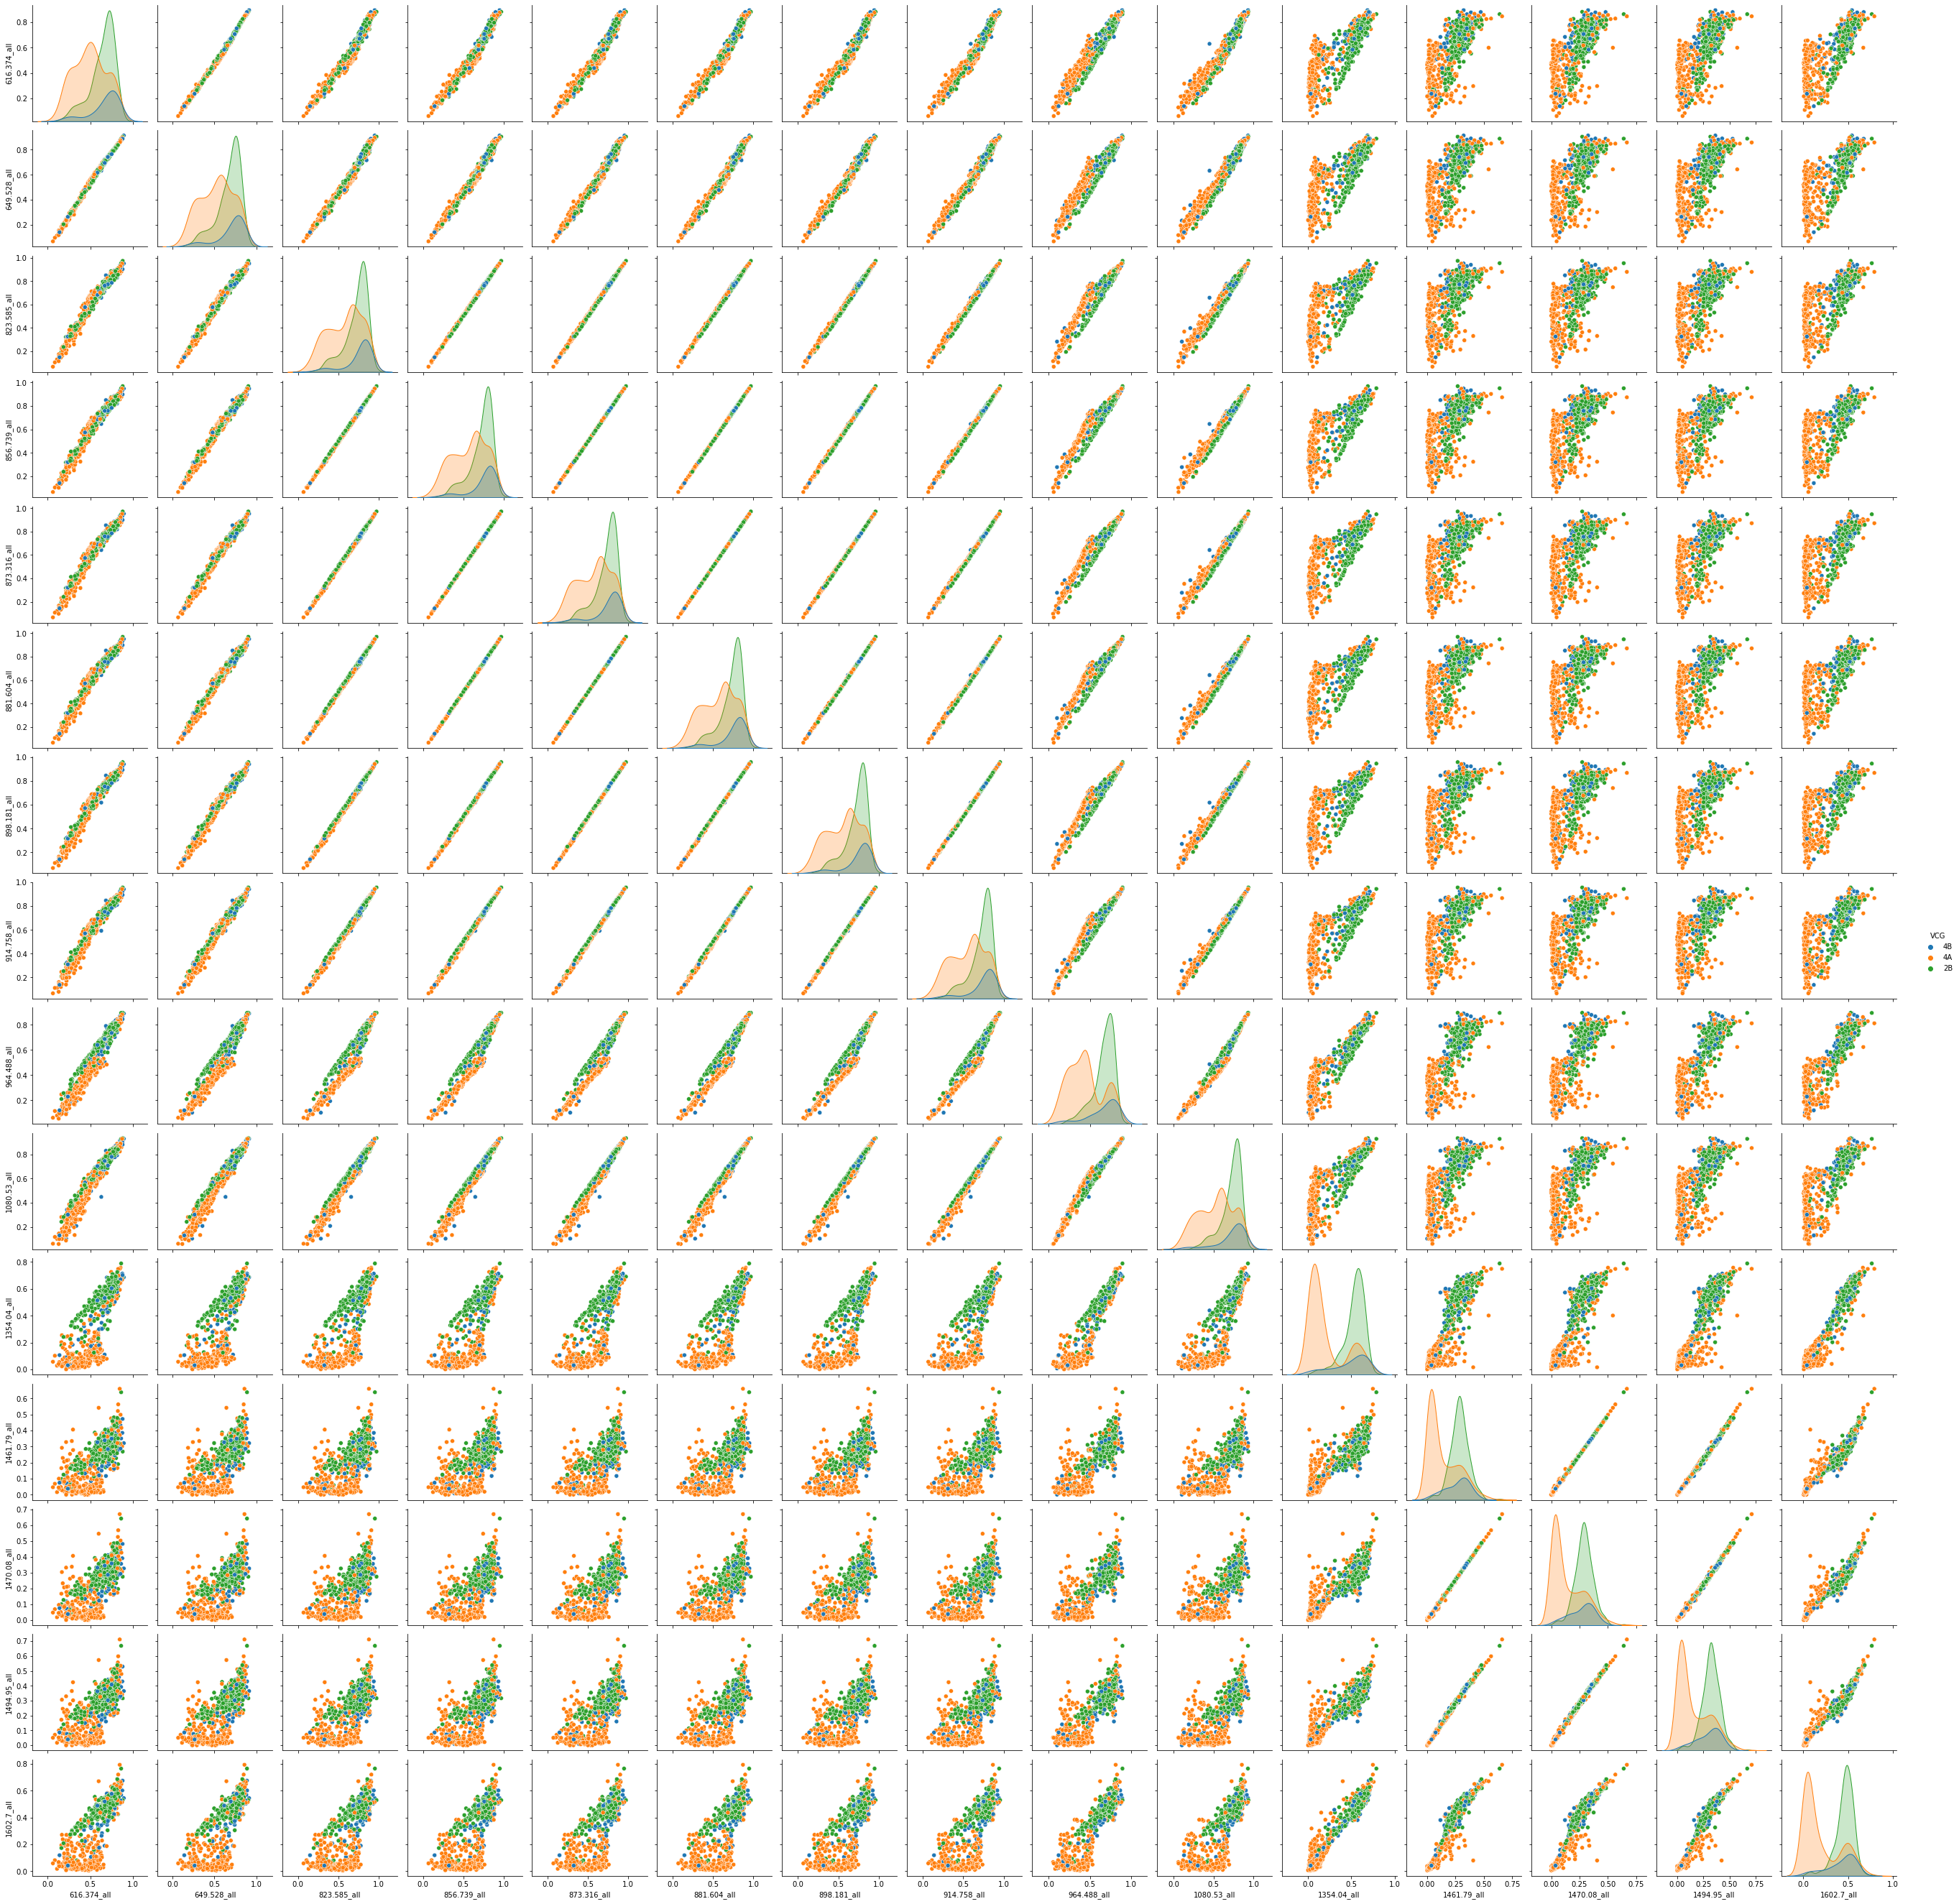

In [8]:
ref_select = pd.concat([features_name.iloc[:,2:], ref_whole.iloc[:,[0,4,25,29,31,32,34,36,42,56,89,102,103,106,119]]], axis =1)
display(ref_select.head(3))
sns.pairplot(data = ref_select , hue = 'VCG')

---

---

---

#### Visualize Average reflectance (Raw)

**Change data to longer format**

In [20]:
ref_select = pd.concat([features_name, ref_whole], axis =1)
melted_ref = ref_select.melt(id_vars = ['Isolate', 'Replication', 'VCG'], var_name = 'Wavelength', value_name = 'Reflectance')
melted_ref['Wavelength'] = melted_ref['Wavelength'].str.split('_').str[0]
melted_ref['Wavelength'] = melted_ref.Wavelength.astype(str).astype(float).round(0).astype(int)
print(melted_ref.head())
print('before: %s, after: %s'%(ref_select.shape, melted_ref.shape))

   Isolate  Replication VCG  Wavelength  Reflectance
0        1            1  4B         616     0.663882
1        1            2  4B         616     0.893261
2        1            3  4B         616     0.716855
3       10            1  4A         616     0.611416
4       10            2  4A         616     0.617135
before: (717, 127), after: (88908, 5)


In [21]:
melted_ref.dtypes

Isolate          int64
Replication      int64
VCG             object
Wavelength       int32
Reflectance    float64
dtype: object

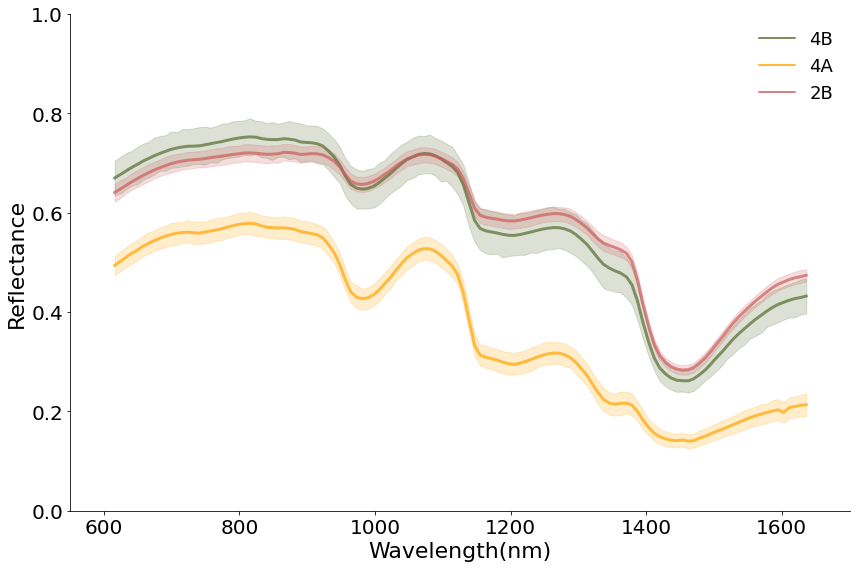

In [25]:
fig, ax = plt.subplots(figsize=(12, 8)) # define a figure and a single axes object
ax = sns.lineplot(ax=ax, data= melted_ref, x='Wavelength', y='Reflectance',  
                  hue='VCG', palette = ['darkolivegreen', 'orange', 'indianred'], linewidth=3, alpha = 0.7)
ax.set_ylabel('Reflectance', fontsize=22)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylim([0,1])
ax.set_xticks([600, 800, 1000, 1200, 1400, 1600])
ax.set_xlim([550, 1700])
ax.set_xlabel('Wavelength(nm)', fontsize=22)
ax.set_xticklabels(ax.get_xticks(), size = 20)
ax.set_yticklabels(ax.get_yticks(), size = 20)
ax.legend(frameon=False, fontsize=18)
ax.spines['right'].set_visible(False) # remove right axis
ax.spines['top'].set_visible(False) # remove top axis
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) # No decimal places
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}')) # Two decimal places
plt.tight_layout()
#plt.savefig('reflectance_raw.png', dpi=300) 
plt.show()

**PCA**
* Unsupervised learning method
* Commonly used feature extraction method
* Projects the data to new dimension where first axis captures the largest possible variance in the dataset  and second is orthogonal to the first axis and goes in the direction of second highest variance in the data

In [277]:
X = X_std

In [27]:
from sklearn.decomposition import PCA # import PCA class from scikit-learn
from matplotlib.colors import ListedColormap
Vd_cmap = ListedColormap(['saddlebrown', 'indianred', 'darkolivegreen']) # hex code

In [28]:
pca = PCA(n_components=3) # first two components
pca_results = pca.fit_transform(X) # fit the model and transform for dimension reduction.
print(pca_results.shape)
pca_scores = pca.explained_variance_ratio_ # PCA scores 
print('variance explained by the first two PCs: {:.2%}, {:.2%}'.format(*pca_scores))

(717, 3)
variance explained by the first two PCs: 93.97%, 4.46%


* Visualize first two components

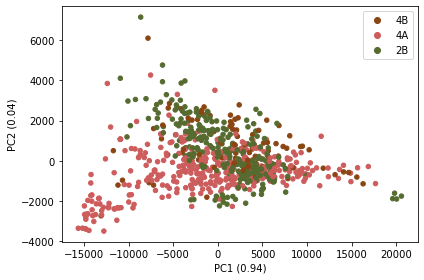

In [29]:
# visualize first two components
fig, ax = plt.subplots(figsize=(6,4))
s1, s2 = pca_results[:, 0], pca_results[:, 1]
scatter = ax.scatter(s1, s2, s=20, c = y, cmap = Vd_cmap, alpha=1)
# legend
hs, _ = scatter.legend_elements() # handlers of the legend
ls = ['4B','4A', '2B'] # labels of the legend
ax.legend(hs, ls)
# labels
ax.set_xlabel('PC1 (%.2f)'%pca_scores[0])
ax.set_ylabel('PC2 (%.2f)'%pca_scores[1])
plt.tight_layout()
#plt.savefig('C:/Users/sudha.gcupadhaya/Desktop/HSIVerticillium-isolates/DataFiles/Figures/PCA_12days_N+S.png', dpi = 300)
plt.show()

---

#### Linear Discriminant Analysis (LDA)

**Linear Discriminant Analysis**
* Parameteric approach
* Supervised learning method
* Commonly used for multiclass classification as an alternative of logistic regression
* Assumption: 
    - The predictor variables have guassian distribution (follows normal distribution/bell shaped curve when plotted and has some correlation between each pairs of predictor) and same covarince matrix among different classes
* LDA estimates the mean vector for each class $(\frac{1}{nk} \sum x)$and common covarince matrix for all class. The prediction is made based probablity value for each class. Linear decision boundaries separate each class
* If $\frac{p}{n}$, (where p= no. of predictiors and n = no. of samples) is larger the model tend to overfit
* Can also be used for dimension reduction. 

Reference
* [James et al. An Introduction to Statistical Learning](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/601cc86d7f828c4792e0bcae/1612499080032/ISLR+Seventh+Printing.pdf)

In [300]:
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.colors import ListedColormap
Vd_cmap = ListedColormap(['saddlebrown', 'indianred', 'darkolivegreen']) # hex code

* Fit the model for dimension reduction

In [301]:
lda = LDA(n_components=2) #define number of components
lda_results = lda.fit_transform(X, y)#fit and tranform for dimension reduction
ld1, ld2 = lda_results[:,0], lda_results[:,1]
lda_scores = lda.explained_variance_ratio_ # Percentage of variance explained by each of the selected components

* Visulaize first two components

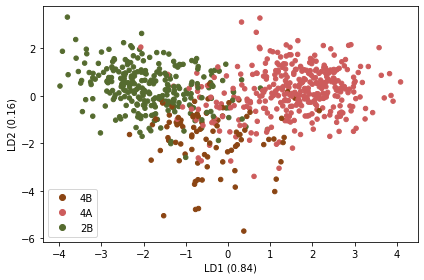

In [302]:
# visualize first two components
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(ld1, ld2, c=y, cmap=Vd_cmap, s=20, alpha=1)
hs, _ = scatter.legend_elements() # handlers of the legend
ls = ['4B','4A', '2B'] # labels of the legend
ax.legend(hs, ls)
ax.set_xlabel('LD1 (%.2f)'%lda_scores[0])
ax.set_ylabel('LD2 (%.2f)'%lda_scores[1])
plt.tight_layout()
#plt.savefig('C:/Users/sudha.gcupadhaya/Desktop/HSIVerticillium-isolates/DataFiles/Figures/PCA_12days_N+S.png', dpi = 300)
plt.show()

---

---

---

**Why modelling?**
* **Prediction**: To predict the output(Y) (in our case vcg groups) based on given predictor varibles(X). We try to minimize the error term by selecting best model or optimiizing the parameters

* **Inference**: when the aim is not only to predict the output but also to understand the relationship between predictor variables and output
    * What predictors are best associated with the outcome? For eg. Identify the import subset of variables or 
    * What is the relationship between input variables and response variables? For eg: either positive or negative relationship
    * Can linear equation summarizes the relationship or the relationship is more complicated?
    
**Why we train multiple models?**

* Each models has their own pros and cons. We will try to find the balance in between this. 
* Since, some model perform best on some dataset and not on others so we want to find the best predictive model that best fits our dataset

**Parametric and non-parametric method**
* Parametric method: Make assumption about data; easy to interpret; tend to have high bias eg: logistic regression
* Non-parametric method: Do not make assumptions about the data; highly flexible but less interpretability; Tend to have high variance; need large no. of training data to accurately predict; If n is small tend to overfit eg: SVM, RF
* Parametric methods out perform non-parametric methods when there is small number of observations per class
* Small sample size: linear methods are much better

**Reference** 
* [James et al. An Introduction to Statistical Learning](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/601cc86d7f828c4792e0bcae/1612499080032/ISLR+Seventh+Printing.pdf)

---